# Riddler Express

>When you started your doctorate several years ago, your astrophysics lab noticed some unusual signals coming in from deep space on a particular frequency — hydrogen times tau. After analyzing a trove of data measured at many regular intervals, you compute that you heard zero signals in 45 percent of the intervals, one signal in 38 percent of the intervals and two signals in the remaining 17 percent of the intervals.

>Your research adviser suggests that it may just be random fluctuations from two sources. Each source had some fixed probability of emitting a signal that you picked up, and together those sources generated the pattern in your data.

>What do you think? Was it possible for your data to have come from two random fluctuations, as your adviser suggests?

Load packages I'll use and set a global path before starting

In [1]:
using Turing, Plots, StatsBase, Distributions, StatsPlots

In [2]:
savedir = "/Users/tburch/Documents/github/puzzles/riddler538_2020_Aug21/plots/";

## Data Generation

Problem indicates that we should simulate data at the rates:

- 45% 0's
- 38% 1's
- 17% 2's

To achieve that, I threw random numbers ($n=25000$) on the interval $[0,1]$ with floating point precision. Then to achieve the proportions as designated, I set all instances on the interval $[0.00, 0.45)$ as 0, $[0.45, 0.83)$ as 1 and $[0.83, 1.00]$ as 2.

In [3]:
obs = 25000 # n_observations

p_sim = rand(obs) # random numbers between 0-1
p_bound0 = .45 # below is 0 case, above 1
p_bound1 = .45+.38; # below is 1 case, above is 2

In [4]:
# Use probabilities thrown to fill 0, 1, or 2
outcomes = []
for i in p_sim
    if i < p_bound0
        push!(outcomes, 0);
    elseif i >= p_bound0 && i < p_bound1
        push!(outcomes, 1);
    else
        push!(outcomes,2);
    end
end

As a cross check, I'll validate the generated rates are consistent with problem by plotting counts of each signal reading value. The y-axis is normalized so that it shows the rate, rather than total count.

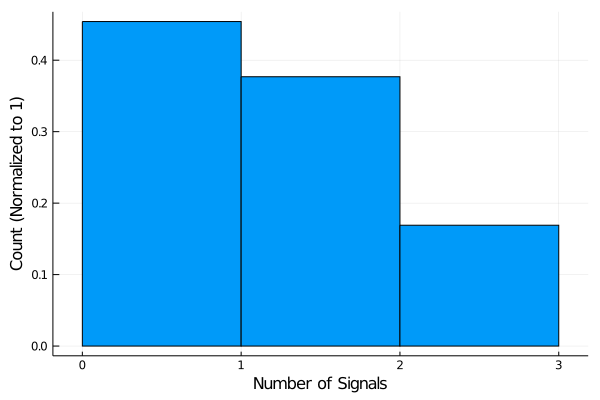

In [5]:
histogram(
    outcomes,
    bins=3,
    xlab="Number of Signals",
    ylab="Count (Normalized to 1)",
    normalize=true,
    legend=false
)

This histogram is consistent with rates given in the problem, so generated data looks valid, and we now have 25,000 observations.

### Model

This data can be modeled using a [Poisson Binomial distribution](https://en.wikipedia.org/wiki/Poisson_binomial_distribution). This distribution is the convolution of $n$ Bernoulli distributed variables, with probability $p_1, p_2, \dots, p_n$. In our case, we have $n=2$ where each source omits a signal with probability $p_i$, for $i=1,2$ during each sampling interval.

Plotting generic Poisson Binomial distributions with $i=2$ for various $p_i$ values:

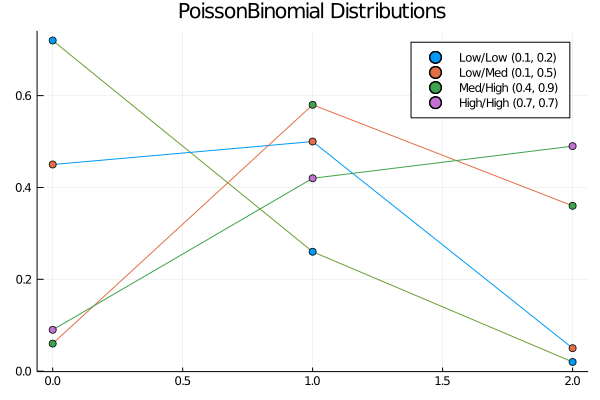

In [6]:
plot(PoissonBinomial([0.1, 0.2]),
    label="Low/Low (0.1, 0.2)",
    title="PoissonBinomial Distributions",
    legend=:best)
plot!(PoissonBinomial([0.1, 0.5]),
    label="Low/Med (0.1, 0.5)")
plot!(PoissonBinomial([0.4, 0.9]),
    label="Med/High (0.4, 0.9)")
plot!(PoissonBinomial([0.7, 0.7]),
    label="High/High (0.7, 0.7)")

Given two sources emitting with some fixed probability, this is the type of distribution I would expect. The distribution is bounded from 0-2, corresponding to neither source, one source, or both sources emitting during a sampling period. If both $p$ values are low, the sources aren't emitting frequently, so we expect many samplings with 0 readings. If both $p$ values are high, we expect many cases in which we receive signals from both, so many 2 readings. Anywhere in the middle, we run into a high degree of one or the other emitting a signal, so 1 is most common. This type of behavior we observe in these generic distributions, so this model seems to fit the problem.

Formalizing the model,

\begin{align*}
    y_i &\sim \text{PoissonBinomial}(\mathbf{p})\\
    p_i &\sim \text{Uniform}(0,1)\\
\end{align*}

Flat priors are used for $p_1$ and $p_2$. Given our data, we see 0 is the most common value, so most likely both $p$ values will be low, below 0.5. However, we were able to simulate many observations, 25,000, which gives the flexibility to have less informative priors, the observations will be the dominant factor in shaping the posterior. 

The flat prior, $\text{Uniform}(0,1)$, does provide information to the model in terms of bounds - on each time interval, each source has between a 0% and 100% chance of emitting. We don't permit for negative or greater than 100% probabilities, since those don't make much physical sense.

### Fitting the model

The [Turing.jl](https://turing.ml/) library is used to construct this model. 10,000 posterior samples are run on 4 chains (definitely overkill, but nothing else is running on my computer overnight). The probabilities $p_i$, are coded as variables p_a and p_b below.

In [7]:
# Model Inputs
N = collect(1:length(outcomes))
y = outcomes
J = length(outcomes)

@model signals(y, J) = begin
    # Parameters
    p_a ~ Uniform(0,1)
    p_b ~ Uniform(0,1)
    
    # Model
    for i in 1:J
        y[i] ~  PoissonBinomial([p_a, p_b])
    end
end

chn = sample(signals(y, length(outcomes)), NUTS(), MCMCThreads(), 10000, 4, progress=true)
    

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/tburch/.julia/packages/AbstractMCMC/iOkTf/src/sample.jl:197
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling (1 threads): 100%|█████████████████████████████████████████| Time: 0:00:00


Object of type Chains, with data of type 9000×14×4 Array{Float64,3}

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 9000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = p_a, p_b

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse         ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ──────────  ──────
         p_a  0.3575  0.0055    0.0000  0.0000  14537.4252  1.0001
         p_b  0.3576  0.0055    0.0000  0.0000  14312.9203  1.0003

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
         p_a  0.3468  0.3537  0.3575  0.3612  0.3683
         p_b  0.3468  0.3539  0.3575  0.3613  0.3684


There's no reason the model ought to prefer one $p$ over another, so it makes sense their mean and standard deviations are the same. The 95% credible intervals are from 0.349 to 0.368, a bit narrower than I would have expected. This means that to see the pattern we've gotten with two sources, both must have a probability of around 0.358 of emitting per sampling period.


Inspecting the chains and posteriors to make sure convergence is good:

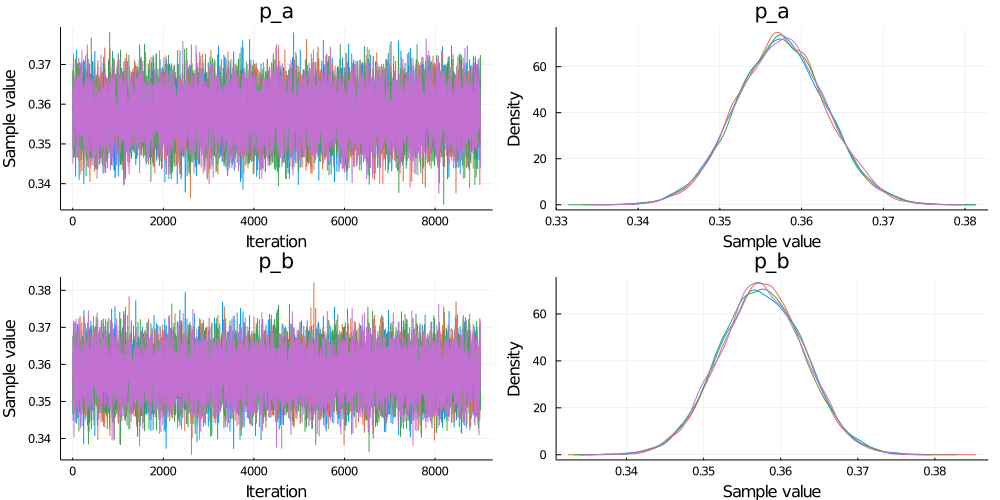

In [8]:
plot(chn)

This all looks normal, the fit appears to have worked well. Distributions appear roughly normal, centered at a mean of 0.358 for both, with a standard deviation of 0.006. Probably the most interesting check is how the emission probabilities covary. 

This solution approach searches for possible parameter values that can realize the observations. Meaning, to get the same observations, as one $p$ value increases, the other $p$ value ought to decrease. In other words, if one source is emitting signals more often, to get the same realized data, the other source must emit less often. Thus, we expect a negative correlation between the two emission probability parameters.

In [9]:
corner(chn)

We see negative correlation. Explicitly getting that value:

In [10]:
p_a_vals = get(chn,:p_a)
p_b_vals = get(chn,:p_b)
round(cor(p_a_vals.p_a[:], p_b_vals.p_b[:]), digits=3)

-0.697

We can see they've got a negative correlation (-0.697), which is exactly what we'd expect - if one source has a slightly higher probability of emission, to realize the same data, the other must have a slightly lower probability per sampling period.

### Final solution

Getting back to the question posed:

>Your research adviser suggests that it may just be random fluctuations from two sources. Each source had some fixed probability of emitting a signal that you picked up, and together those sources generated the pattern in your data.

>What do you think? Was it possible for your data to have come from two random fluctuations, as your adviser suggests?

This analysis shows, yes, this is definitely possible. If it were true, we would expect both sources to have between a 34.7% and 36.8% probability of emitting a signal each sampling period, the 95% credible interval. The mean emission probability per sampling period we expect from either source 35.8%, with a standard deviation of 0.6%.

### Investigating Extrema

With so many posterior samples, its interesting from a sheer curiosity standpoint to look at the most extreme values that could result in this dataset. If one is emitting with the highest possible probability to realize this data, what is that probability? Subsequently, how infrequent would the other have to emit in this scenario?

In [13]:
max_a = argmax(p_a_vals.p_a[:])
println(string("Highest p_a: ", round(p_a_vals.p_a[max_a], digits=4),
        " with corresponding p_b: ", round(p_b_vals.p_b[max_a],digits=4)))
max_b = argmax(p_b_vals.p_b[:])
println(string("Highest p_b: ", round(p_b_vals.p_b[max_b], digits=4), 
            " with corresponding p_a: ", round(p_a_vals.p_a[max_b],digits=4)))
min_a = argmin(p_a_vals.p_a[:])
println(string("Lowest p_a: ", round(p_a_vals.p_a[min_a], digits=4),
        " with corresponding p_b: ", round(p_b_vals.p_b[min_a],digits=4)))
min_b = argmin(p_b_vals.p_b[:])
println(string("Lowest p_b: ", round(p_b_vals.p_b[min_b], digits=4), 
            " with corresponding p_a: ", round(p_a_vals.p_a[min_b],digits=4)))


Highest p_a: 0.3781 with corresponding p_b: 0.3427
Highest p_b: 0.3822 with corresponding p_a: 0.3435
Lowest p_a: 0.3347 with corresponding p_b: 0.3757
Lowest p_b: 0.3356 with corresponding p_a: 0.375


The highest emission probability consistent with our data was found to be $p = 0.382$, where the corresponding probability from the second source is $p = 0.344$ (outside the lower limits of the 95% credible interval, expected due to covariance).

The lowest emission probability was found to be $p=0.335$, with a corresponding probability from the second source of $p=0.378$ (outside upper limits of 95% credible credible interval).

As mentioned, these are the most extreme values, so very, very unlikely to be realized, and we should lend effectively no belief to values below $p=0.33$ or above $p=0.39$.